## Goal: How many SIRVs / ERCCs do we detect? 

* For spliced sirvs, what novelty distribution do they have? 

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import yaml
from snakemake.io import expand
import pyranges as pr
from pyfaidx import Fasta
from mizani.formatters import percent_format
from scipy import stats


p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

from plotnine import *

In [2]:
def my_theme(base_size=11, w=4, h=3):
    """
    Custom plotnine theme with:
    - White background
    - Clean styling
    - Axes and ticks retained

    Parameters:
    - base_size: Base font size

    Returns:
    - plotnine.theme object
    """
    return (
        theme_minimal(base_size=base_size)
        + theme(
            # White background
            panel_background=element_rect(fill='white', color=None),
            plot_background=element_rect(fill='white', color=None),

            # Remove grid lines
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            panel_border=element_blank(),

            # Keep axis lines & ticks (don't blank them)
            axis_line=element_line(color='black'),
            axis_ticks=element_line(color='black'),

            plot_title=element_text(hjust=0.5, family='Helvetica'),
            axis_title_x=element_text(hjust=0.5, family='Helvetica'),
            axis_title_y=element_text(hjust=0.5, margin={'t':0, 'r':-2, 'b':0, 'l':0}, family='Helvetica'),
            
            # Styling text
            legend_title=element_blank(),
            axis_title=element_text(size=base_size + 1, family='Helvetica'),
            legend_text=element_text(size=base_size-2, family='Helvetica'),
            axis_text=element_text(size=base_size, color='black', family='Helvetica'),
            figure_size=(w, h),  # Controls plot dimensions (width x height in inches)
            plot_margin=0.05      # Shrinks surrounding white space
        )
    )

def clean_figure(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis="x", rotation=45)

In [247]:
config = load_config()
od = '../'
meta_df = load_meta()
meta_df['lab_sample'] = meta_df['lab_number_sample'].astype(str)+'_'+\
                        meta_df['lab_sampleid']+'_'+\
                        meta_df['cell_line_id']


def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [386]:
f = proc_cfg(expand(config['lr']['qc_sirvs']['sqanti_reads']['class_summary'],
                    annot_completeness='C')[0], od)
df = pd.read_csv(f, sep='\t')

# rename structural categories
m = {'antisense': 'Antisense',
     'full-splice_match': 'FSM',
     'genic': 'Genic', 
     'incomplete-splice_match': 'ISM',
     'intergenic': 'Intergenic',
     'novel_in_catalog': 'NIC',
     'novel_not_in_catalog': 'NNC'}
df['structural_category'] = df.structural_category.map(m)

# add antisense gene ids as assc_gene_2
df['assc_gene_2'] = df.associated_gene
inds = df.loc[df.structural_category=='Antisense'].index
df.loc[inds, 'assc_gene_2'] = df.loc[inds, 'assc_gene_2'].str.split('_', expand=True)[1]

# add relevant metadata
df = df.merge(meta_df[['lab_sample', 'population']], 
              how='left', on='lab_sample')

# add # mapped reads 
df['n_mapped_reads'] = df.groupby('lab_sample')['isoform'].transform('count')

# add spike type
df['spike_type'] = np.nan
df.loc[df.chrom.str.contains('ERCC'), 'spike_type'] = 'ERCC'
df.loc[df.chrom.str.contains('SIRV'), 'spike_type'] = 'SIRV'

spliced_sirvs = ['SIRV1', 'SIRV2', 'SIRV3', 'SIRV4', 'SIRV5', 'SIRV6', 'SIRV7']
df.loc[df.chrom.isin(spliced_sirvs), 'spike_type_2'] = 'spliced_sirv'

# add # spliced sirv reads
df['n_spliced_sirv_reads'] = df.loc[df.spike_type_2=='spliced_sirv'].groupby('lab_sample')['isoform'].transform('count')

# splicing novelty
df['splicing_novelty'] = 'Novel'
df.loc[df.structural_category.isin(['FSM', 'ISM']), 'splicing_novelty'] = 'Known'

# overal known vs. novel
df['overall_nov'] = 'Novel'
df.loc[df.structural_category == 'FSM', 'overall_nov'] = 'Known'

/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_58538/1093789222.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'ERCC' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.


## Ground truth -- the sirv / ercc gtf

In [387]:
gtf_df = pr.read_gtf('../data/qc_sirvs/SIRV_ERCC_longSIRV_multi-fasta_20210507.gtf').df

temp = gtf_df.loc[gtf_df.Chromosome.isin(spliced_sirvs)]
n_spliced_sirvs_tot = len(temp.transcript_id.unique())

# there are 69 spliced sirvs as ground truth

# get the transcript length of each sirv transcript
gtf_df['exon_len'] = gtf_df['End'] - gtf_df['Start']
gtf_df['transcript_len'] = gtf_df.groupby('transcript_id')['exon_len'].transform('sum')

gtf_df['mean_transcript_len'] = gtf_df.groupby('gene_id')['transcript_len'].transform('mean')
gtf_df['med_transcript_len'] = gtf_df.groupby('gene_id')['transcript_len'].transform('median')

# also get number of exons
gtf_df['n_exons'] = gtf_df.groupby('transcript_id')['exon_assignment'].transform('count')
gtf_df['mean_n_exons'] = gtf_df.groupby('gene_id')['n_exons'].transform('mean')
gtf_df['med_n_exons'] = gtf_df.groupby('gene_id')['n_exons'].transform('median')

# also get number of transcripts
gtf_df['n_transcripts'] = gtf_df.groupby('gene_id')['transcript_id'].transform('nunique')

In [457]:
gtf_df.loc[gtf_df.n_exons==1][['transcript_id', 'n_exons']].drop_duplicates()

,transcript_id,n_exons
125,SIRV205,1
126,SIRV206,1
195,SIRV311,1
256,SIRV504,1
322,SIRV512,1
340,SIRV603,1
412,SIRV617,1
413,SIRV618,1
449,SIRV4001,1
450,SIRV4002,1


## What % of reads per sample belong to different nov. cats for spliced sirvs?

In [388]:
temp = df.loc[df.spike_type_2=='spliced_sirv']
gb_cols = ['structural_category','lab_sample', 'n_spliced_sirv_reads', 'n_mapped_reads', 'population']
keep_cols = gb_cols+['isoform']
temp = temp[keep_cols].groupby(gb_cols).count().reset_index().rename({'isoform':'n_reads_cat'}, axis=1)
temp['perc'] = (temp.n_reads_cat/temp.n_spliced_sirv_reads)*100
temp.head()

,structural_category,lab_sample,n_spliced_sirv_reads,n_mapped_reads,population,n_reads_cat,perc
0,Antisense,10_NI5_GM19117,3344.0,8289,YRI,39,1.166268
1,Antisense,11_NI6_GM19129,3983.0,8911,YRI,69,1.732363
2,Antisense,12_NI7_GM19240,3967.0,8195,YRI,270,6.806151
3,Antisense,13_CH1_GM18542,5559.0,10245,HAC,513,9.228278
4,Antisense,14_CH2_GM18561,2520.0,4966,HAC,34,1.349206


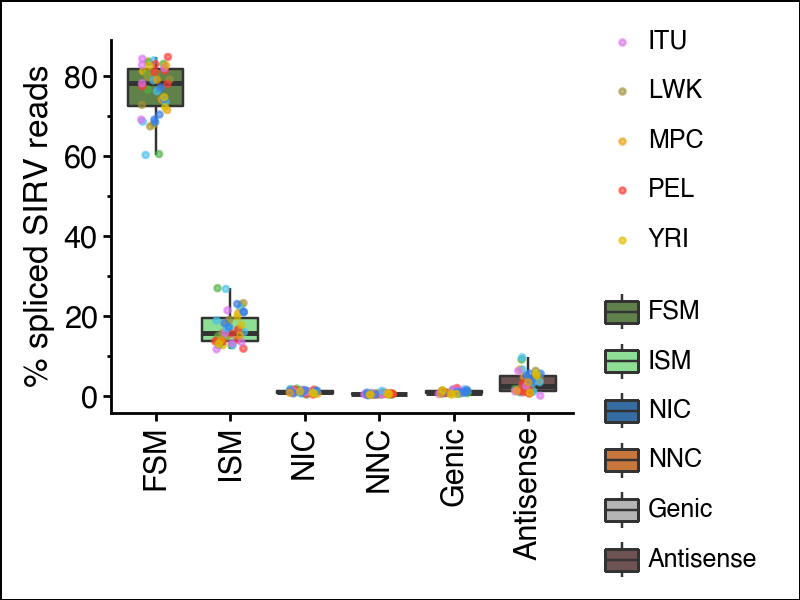

In [389]:
c_dict, order = get_novelty_colors(temp.structural_category.unique().tolist())
temp['structural_category'] = pd.Categorical(temp['structural_category'], categories=order, ordered=True)
p = (
    ggplot(temp, aes(x='structural_category', y='perc'))
    + geom_boxplot(aes(fill='structural_category'), outlier_shape='')
    # + geom_jitter(aes(color='population', size='n_mapped_reads'), width=0.2, alpha=0.6)
    + geom_jitter(aes(color='population'), width=0.2, alpha=0.6, size=0.75)
    + scale_color_manual(values=pop_c_dict)
    + scale_fill_manual(c_dict)
    # + scale_size_continuous(range=(0.25, 2))
    + labs(
        x='',
        y='% spliced SIRV reads',
        fill='Read structural category'
    )
    + my_theme(w=4, h=3)
    + theme(axis_text_x=element_text(rotation=90))
)
p.show()

In [390]:
temp.groupby('structural_category')['perc'].median()

/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_58538/3011610163.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


structural_category
FSM          78.268945
ISM          15.898960
NIC           1.161318
NNC           0.624400
Genic         0.995025
Antisense     2.674591
Name: perc, dtype: float64

In [391]:
temp.groupby('structural_category')['perc'].mean()


/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_58538/1749089081.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


structural_category
FSM          76.748970
ISM          17.015123
NIC           1.193413
NNC           0.638521
Genic         1.083470
Antisense     3.320503
Name: perc, dtype: float64

## What if we just split by known / novel splicing?

In [392]:
temp = df.loc[df.spike_type_2=='spliced_sirv']
gb_cols = ['splicing_novelty','lab_sample', 'n_spliced_sirv_reads', 'n_mapped_reads', 'population']
keep_cols = gb_cols+['isoform']
temp = temp[keep_cols].groupby(gb_cols).count().reset_index().rename({'isoform':'n_reads_cat'}, axis=1)
temp['perc'] = (temp.n_reads_cat/temp.n_spliced_sirv_reads)*100

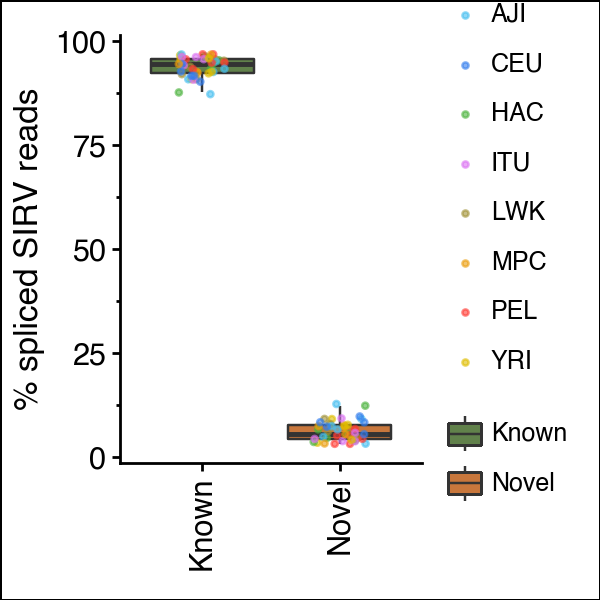

In [393]:
c_dict, order = get_novelty_colors()
sn_c_dict = {'Known': c_dict['FSM'],
             'Novel': c_dict['NNC']}
sn_order = ['Known', 'Novel']

temp['structural_category'] = pd.Categorical(temp['splicing_novelty'], categories=sn_order, ordered=True)
p = (
    ggplot(temp, aes(x='splicing_novelty', y='perc'))
    + geom_boxplot(aes(fill='splicing_novelty'), outlier_shape='')
    # + geom_jitter(aes(color='population', size='n_mapped_reads'), width=0.2, alpha=0.6)
    + geom_jitter(aes(color='population'), width=0.2, alpha=0.6, size=0.75)
    + scale_color_manual(values=pop_c_dict)
    + scale_fill_manual(sn_c_dict)
    # + scale_size_continuous(range=(0.25, 2))
    + labs(
        x='',
        y='% spliced SIRV reads',
        fill='Splicing novelty'
    )
    + my_theme(w=3, h=3)
    + theme(axis_text_x=element_text(rotation=90))
)
p.show()

In [394]:
temp.groupby('splicing_novelty')['perc'].median()

splicing_novelty
Known    94.470546
Novel     5.529454
Name: perc, dtype: float64

In [395]:
temp.groupby('splicing_novelty')['perc'].mean()

splicing_novelty
Known    93.764093
Novel     6.235907
Name: perc, dtype: float64

In [396]:
df.loc[df.spike_type_2 == 'spliced_sirv'].associated_gene.unique()

array(['SIRV1', 'novelGene_SIRV1_AS', 'SIRV2', 'novelGene_SIRV2_AS',
       'SIRV3', 'novelGene_SIRV3_AS', 'SIRV4', 'novelGene_SIRV4_AS',
       'SIRV5', 'novelGene_SIRV5_AS', 'SIRV6', 'novelGene_SIRV6_AS',
       'SIRV7', 'novelGene_SIRV7_AS'], dtype=object)

## What % of antisense reads per sample are from SIRV7?

In [397]:
temp = df.loc[df.spike_type_2=='spliced_sirv']
temp = temp.loc[temp.structural_category == 'Antisense']

temp['n_antisense_reads'] = temp.groupby('lab_sample')['isoform'].transform('count')

gb_cols = ['assc_gene_2', 'lab_sample', 'n_spliced_sirv_reads', 'n_antisense_reads', 'n_mapped_reads', 'population']
keep_cols = gb_cols+['isoform']
temp = temp[keep_cols].groupby(gb_cols).count().reset_index().rename({'isoform':'n_antisense_reads_gene'}, axis=1)
temp['perc'] = (temp.n_antisense_reads_gene/temp.n_antisense_reads)*100

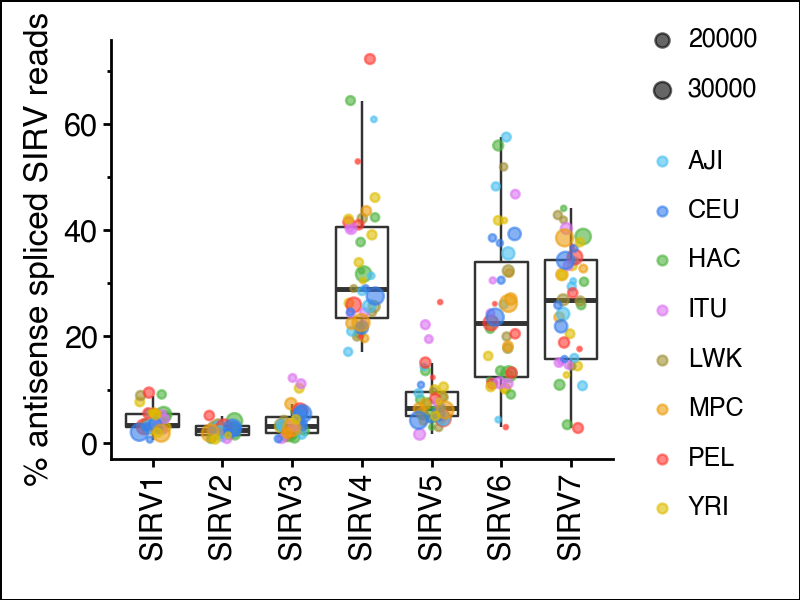

In [398]:
temp['assc_gene_2'] = pd.Categorical(temp['assc_gene_2'], categories=sirv_order, ordered=True)

p = (
    ggplot(temp, aes(x='assc_gene_2', y='perc'))
    + geom_boxplot(outlier_shape='')
    + geom_jitter(aes(color='population', size='n_mapped_reads'), width=0.2, alpha=0.6)
    + scale_size_continuous(range=(0.25, 3))
    # + geom_jitter(aes(color='population'), width=0.2, alpha=0.6, size=0.75)
    + scale_color_manual(values=pop_c_dict)
    + labs(
        x='',
        y='% antisense spliced SIRV reads',
    )
    + my_theme(w=4, h=3)
    + theme(axis_text_x=element_text(rotation=90))
)
p.show()

## How many reads do we even have overall for each gene?

/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_58538/4055843649.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_58538/4055843649.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_58538/4055843649.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

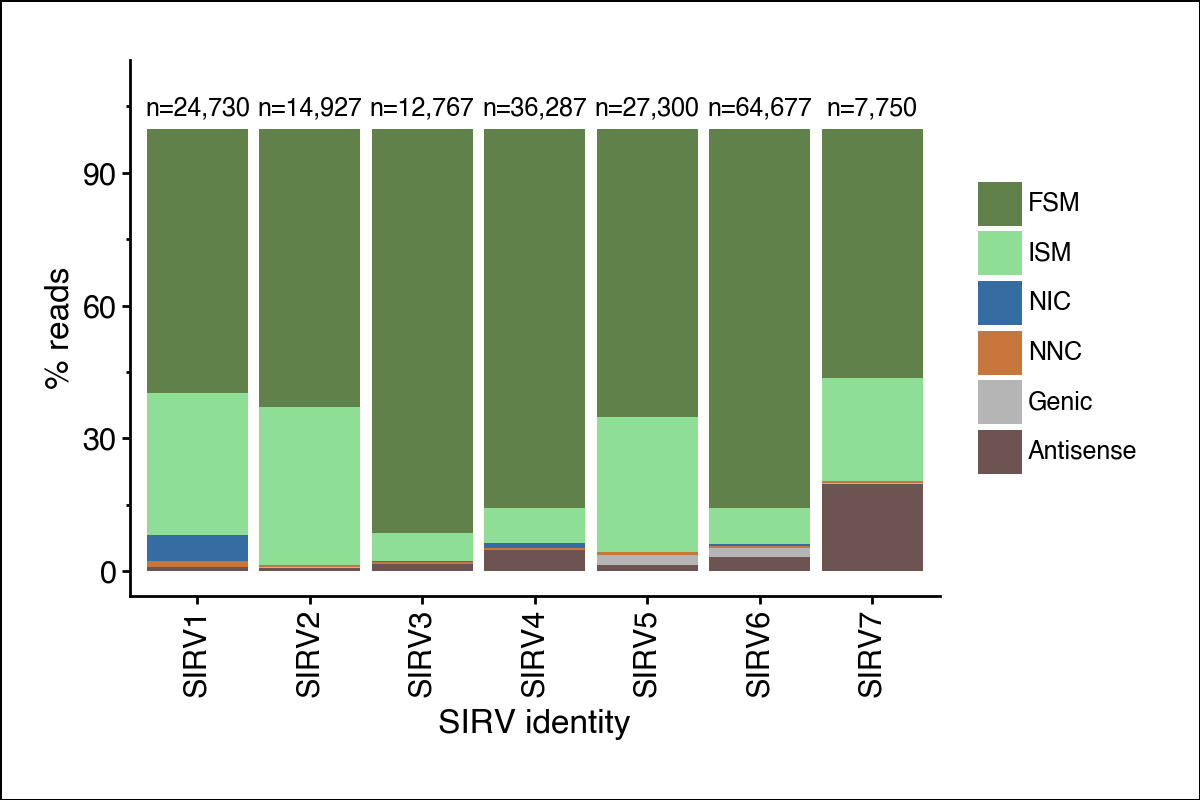

In [399]:
temp = df.loc[df.spike_type_2=='spliced_sirv']

temp['n_reads_sirv'] = temp.groupby('assc_gene_2')['isoform'].transform('nunique')
temp['n_reads_sirv_cat'] = temp.groupby(['assc_gene_2', 'structural_category'])['isoform'].transform('nunique')

c_dict, order = get_novelty_colors(temp.structural_category.unique().tolist())
temp['structural_category'] = pd.Categorical(temp['structural_category'], categories=order, ordered=True)

temp['perc'] = (temp.n_reads_sirv_cat/temp.n_reads_sirv)*100
temp = temp[['assc_gene_2', 'structural_category', 'perc', 'n_reads_sirv', 'n_reads_sirv_cat']].drop_duplicates()


# (
#     ggplot(temp, aes(x='assc_gene_2', y='perc', fill='factor(structural_category)'))
#     + geom_bar(stat='identity', position='stack')
#     +scale_fill_manual(c_dict)
#     # + scale_y_continuous(labels=percent_format(), expand=(0, 0))
#     + labs(
#         x='SIRV identity',
#         y='% reads',
#         fill='Read structural category'
#     )
#     + my_theme(w=6, h=4)
#     + theme(axis_text_x=element_text(rotation=90))
# )

from plotnine import *

# Compute bar tops and make label column
label_df = (
    temp.groupby('assc_gene_2', as_index=False)
        .agg({'perc': 'sum', 'n_reads_sirv': 'first'})
)
label_df['label'] = label_df['n_reads_sirv'].apply(lambda x: f"n={x:,}")

(
    ggplot(temp, aes(x='assc_gene_2', y='perc', fill='structural_category'))
    + geom_bar(stat='identity', position='stack')
    + geom_text(
        inherit_aes=False,
        data=label_df,
        mapping=aes(
            x='assc_gene_2',
            y='perc',
            label='label'
        ),
        va='bottom',
        nudge_y=2,
        size=9
    )
    + scale_fill_manual(c_dict)
    + labs(
        x='SIRV identity',
        y='% reads',
        fill='Read structural category'
    )
    + my_theme(w=6, h=4)
    + theme(axis_text_x=element_text(rotation=90))
    + ylim(0, 110)

)


## Ok, what happens when we reimplement our filters?
* Limit to spliced SIRVs
* Require that novel transcripts are in >=2 samples
* Promote ISMs to their FSMs if the FSM is not already observed in the sample
* Following the previous step, remove all ISMs
* Finally, remove all monoexonic

In [460]:
temp = df.loc[df.spike_type_2=='spliced_sirv']
temp['filter_pass'] = False

/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_58538/2384217657.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [461]:
# filter 1 -- novel transcripts must be present in 2+ samples
temp['sample_sharing'] = temp.groupby('jxnHash')['lab_sample'].transform('nunique')
temp.loc[temp.sample_sharing>=2, 'filter_pass'] = True

/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_58538/550596551.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


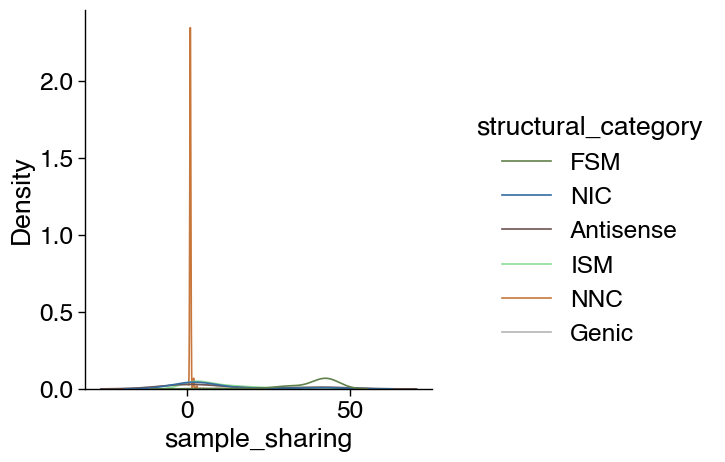

In [462]:
temp2 = temp[['jxnHash', 'structural_category', 'sample_sharing']].drop_duplicates()
init_plot_settings()
sns.displot(temp2,
            hue='structural_category',
            x='sample_sharing',
            kind='kde',
            palette=c_dict,
            common_norm=False)
plt.show()

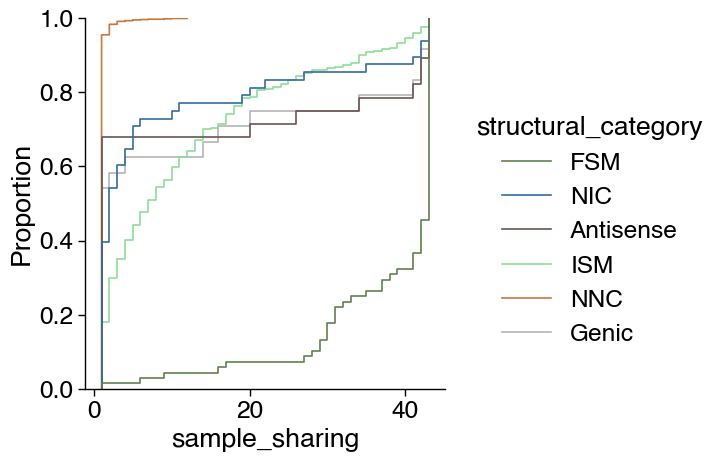

In [463]:
temp2 = temp[['jxnHash', 'structural_category', 'sample_sharing']].drop_duplicates()
init_plot_settings()
sns.displot(temp2,
            hue='structural_category',
            x='sample_sharing',
            kind='ecdf',
            palette=c_dict)
plt.show()

In [ ]:
# filter 2 - for ISMs, if associated_transcript is not in original collection, add it and pass it

# first, mark all ISMs as non-passing
temp.loc[temp.structural_category=='ISM', 'filter_pass'] = False

# get a random fsm entry to add for each uniq one
fsm_temp = temp.loc[(temp.structural_category=='FSM')].drop_duplicates(subset='associated_transcript', keep='first')
fsm_temp['lab_sample'] = np.nan
assert len(fsm_temp.index) == n_spliced_sirvs_tot

# now loop through lab samples and tack on undet. entries FSMs
# for all ISMs
add_df = pd.DataFrame()
for s in temp.lab_sample.unique():
    undet_fsms_from_isms = temp.loc[(temp.lab_sample==s)&\
                                    (temp.structural_category=='ISM')]
    
    temp2 = temp.loc[temp.lab_sample==s]

    # these are the ids of transcripts that are detected via isms
    ism_fsm_ids = temp2.loc[(temp2.structural_category=='ISM'),
                           'associated_transcript'].unique().tolist()
    
    # these are the ids of transcripts that are detected via fsms
    fsm_ids = temp2.loc[(temp2.structural_category=='FSM'),
                        'associated_transcript'].unique().tolist()
    
    # the set difference will be the ones we need to "promote"
    promote_fsm_ids = list(set(ism_fsm_ids)-set(fsm_ids))
    promote_fsm_ids
    
    add_df_temp = fsm_temp.loc[fsm_temp.associated_transcript.isin(promote_fsm_ids)]
    add_df_temp['lab_sample'] = s
    add_df_temp['promoted_ism'] = True
    
    add_df = pd.concat([add_df, add_df_temp], axis=0)

temp = pd.concat([temp, add_df], axis=0)

/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_58538/461803973.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_58538/461803973.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_58538/461803973.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [ ]:
# filter 0 -- all FSMs pass filtering
temp.loc[temp.structural_category == 'FSM', 'filter_pass'] = True

In [ ]:
# filter 3 -- all monoexonics fail filtering 
temp.loc[temp.exons == 1, 'filter_pass'] = False

In [ ]:
# now reduce to just uniq junction chains
keep_cols = ['structural_category', 'associated_transcript', 'exons','jxnHash', 'assc_gene_2',
             'lab_sample', 'population',
             'n_mapped_reads', 'spike_type', 'spike_type_2', 'n_spliced_sirv_reads',
             'splicing_novelty', 'overall_nov', 'filter_pass', 'sample_sharing', 'promoted_ism']
temp = temp[keep_cols].drop_duplicates()

In [ ]:
stat_df = pd.DataFrame()

# add # tp for each sample
temp['n_det_per_cat'] = temp.groupby(['lab_sample', 'structural_category', 'filter_pass'])['associated_transcript'].transform('nunique')
stat_df = pd.concat([stat_df, temp.loc[(temp.structural_category=='FSM')&\
                                       (temp.filter_pass==True)][['lab_sample', 'n_det_per_cat']]], axis=0)
stat_df.rename({'n_det_per_cat':'n_tp'}, axis=1, inplace=True)

# add # fp for each sample. for novels, have to use jxnHash instead of ID
temp['n_det_per_cat_2'] = temp.groupby(['lab_sample', 'overall_nov', 'filter_pass'])['jxnHash'].transform('nunique')
stat_df = stat_df.merge(temp.loc[(temp.overall_nov=='Novel')&\
                                 (temp.filter_pass==True)][['lab_sample', 'n_det_per_cat_2']], 
                       how='left',
                       on='lab_sample')
stat_df.rename({'n_det_per_cat_2':'n_fp'}, axis=1, inplace=True)

# add # fn for each sample. 
tids = gtf_df.loc[gtf_df.gene_id.isin(spliced_sirvs)].transcript_id.unique().tolist()
assert len(tids) == 69
stat_df['n_fn'] = len(tids)-stat_df['n_tp']

In [ ]:
stat_df

In [456]:
# temp.loc[(temp.lab_sample=='1_PY1_GM10492')&\
#          (temp.filter_pass==True)&\
#          (temp.overall_nov=='Novel')].head()

,structural_category,associated_transcript,exons,jxnHash,assc_gene_2,lab_sample,population,n_mapped_reads,spike_type,spike_type_2,n_spliced_sirv_reads,splicing_novelty,overall_nov,filter_pass,sample_sharing,promoted_ism,n_det_per_cat,n_det_per_cat_2
424664,NIC,novel,3,9eb928a180a522a3c8a6b75a9b37cd4f26b1151bee7775...,SIRV1,1_PY1_GM10492,MPC,6914,SIRV,spliced_sirv,3131.0,Novel,Novel,True,43,NaN,1,10
425565,NIC,novel,3,1747605af5e30031f101b2fc2e8b552028af05a585d2b4...,SIRV3,1_PY1_GM10492,MPC,6914,SIRV,spliced_sirv,3131.0,Novel,Novel,True,5,NaN,1,10
425655,NIC,novel,5,3c7b4f7114c74faf05e1d0eeae561aeddf9a8aba63cc07...,SIRV4,1_PY1_GM10492,MPC,6914,SIRV,spliced_sirv,3131.0,Novel,Novel,True,42,NaN,1,10
425734,NIC,novel,4,6347b15f72add0920ff7497ea08a2fb622c244dad47d03...,SIRV4,1_PY1_GM10492,MPC,6914,SIRV,spliced_sirv,3131.0,Novel,Novel,True,6,NaN,1,10
425989,NIC,novel,4,04eb85c3849e4d161fb5f40181655b69c694066e25c391...,SIRV4,1_PY1_GM10492,MPC,6914,SIRV,spliced_sirv,3131.0,Novel,Novel,True,41,NaN,1,10


## Older

In [5]:
df[['isoform', 'structural_category']].groupby('structural_category').nunique()

,isoform
structural_category,
Antisense,8070
FSM,145915
Genic,2153
ISM,32230
Intergenic,236122
NIC,2197
NNC,1147


In [6]:
df['spike_type'] = np.nan
df.loc[df.chrom.str.contains('ERCC'), 'spike_type'] = 'ERCC'
df.loc[df.chrom.str.contains('SIRV'), 'spike_type'] = 'SIRV'
df.loc[df.spike_type.isnull()]


/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_58538/2426860951.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'ERCC' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.


,isoform,chrom,strand,length,exons,structural_category,associated_gene,associated_transcript,ref_length,ref_exons,...,polyA_motif,polyA_dist,polyA_motif_found,ORF_seq,ratio_TSS,jxn_string,jxnHash,lab_sample,assc_gene_2,spike_type


In [7]:
df[['isoform',
    'structural_category',
    'spike_type']].groupby(['structural_category', 'spike_type']).nunique()

,,isoform
structural_category,spike_type,
Antisense,SIRV,8070
FSM,SIRV,145915
Genic,SIRV,2153
ISM,SIRV,32230
Intergenic,ERCC,236122
NIC,SIRV,2197
NNC,SIRV,1147


## Breakdown of novelty categories by the different SIRV identities

In [31]:
# sort the long sirvs at least by length
sirv_order = ['1', '2', '3', '4', '5', '6', '7',
              '4001', '4002', '4003',
              '6001', '6002', '6003', 
              '8001', '8002', '8003',
              '10001', '10002', '10003',
              '12001', '12002', '12003']
sirv_order = [f'SIRV{s}' for s in sirv_order]

/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_58538/2283375035.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_58538/2283375035.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_58538/2283375035.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

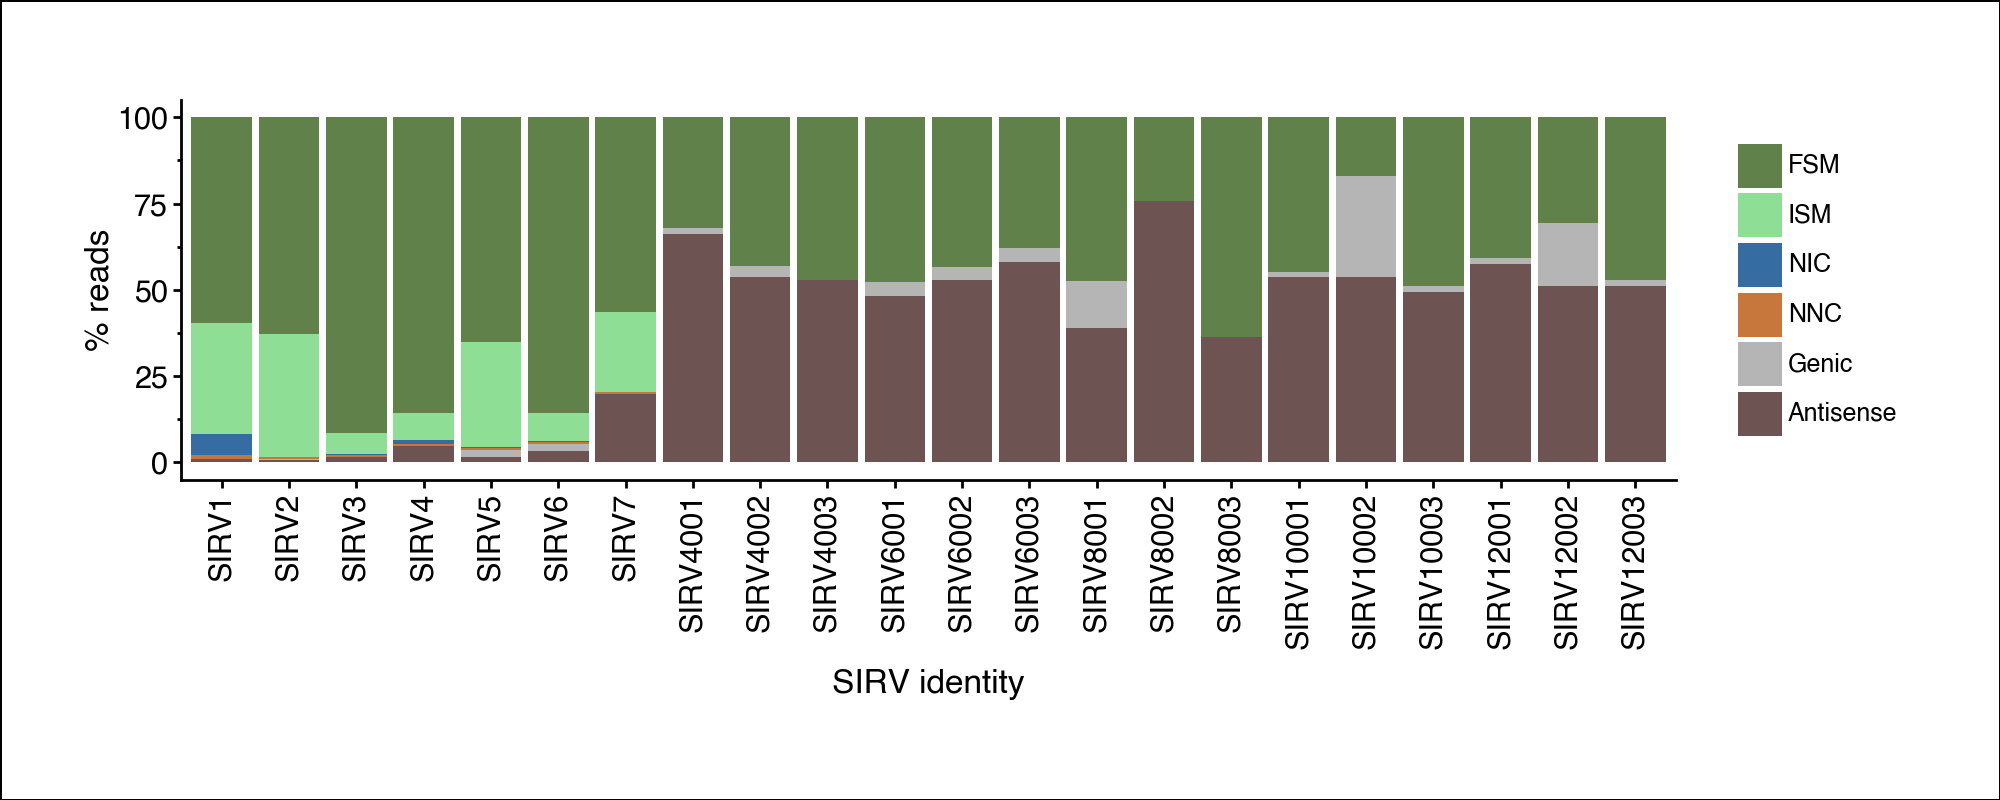

In [32]:
temp = df.loc[df.spike_type == 'SIRV']
temp['n_reads_sirv'] = temp.groupby('assc_gene_2')['isoform'].transform('nunique')
temp['n_reads_sirv_cat'] = temp.groupby(['assc_gene_2', 'structural_category'])['isoform'].transform('nunique')

temp['perc'] = (temp.n_reads_sirv_cat/temp.n_reads_sirv)*100
temp = temp[['assc_gene_2', 'structural_category', 'perc']].drop_duplicates()

c_dict, order = get_novelty_colors(temp.structural_category.unique().tolist())
temp['assc_gene_2'] = pd.Categorical(temp['assc_gene_2'], categories=sirv_order, ordered=True)
temp['structural_category'] = pd.Categorical(temp['structural_category'], categories=order, ordered=True)

(
    ggplot(temp, aes(x='assc_gene_2', y='perc', fill='factor(structural_category)'))
    + geom_bar(stat='identity', position='stack')
    +scale_fill_manual(c_dict)
    # + scale_y_continuous(labels=percent_format(), expand=(0, 0))
    + labs(
        x='SIRV identity',
        y='% reads',
        fill='Read structural category'
    )
    + my_theme(w=10, h=4)
    + theme(axis_text_x=element_text(rotation=90))
)

## Is this antisense enrichment consistent across the libraries?

/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_58538/4268389056.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_58538/4268389056.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_58538/4268389056.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

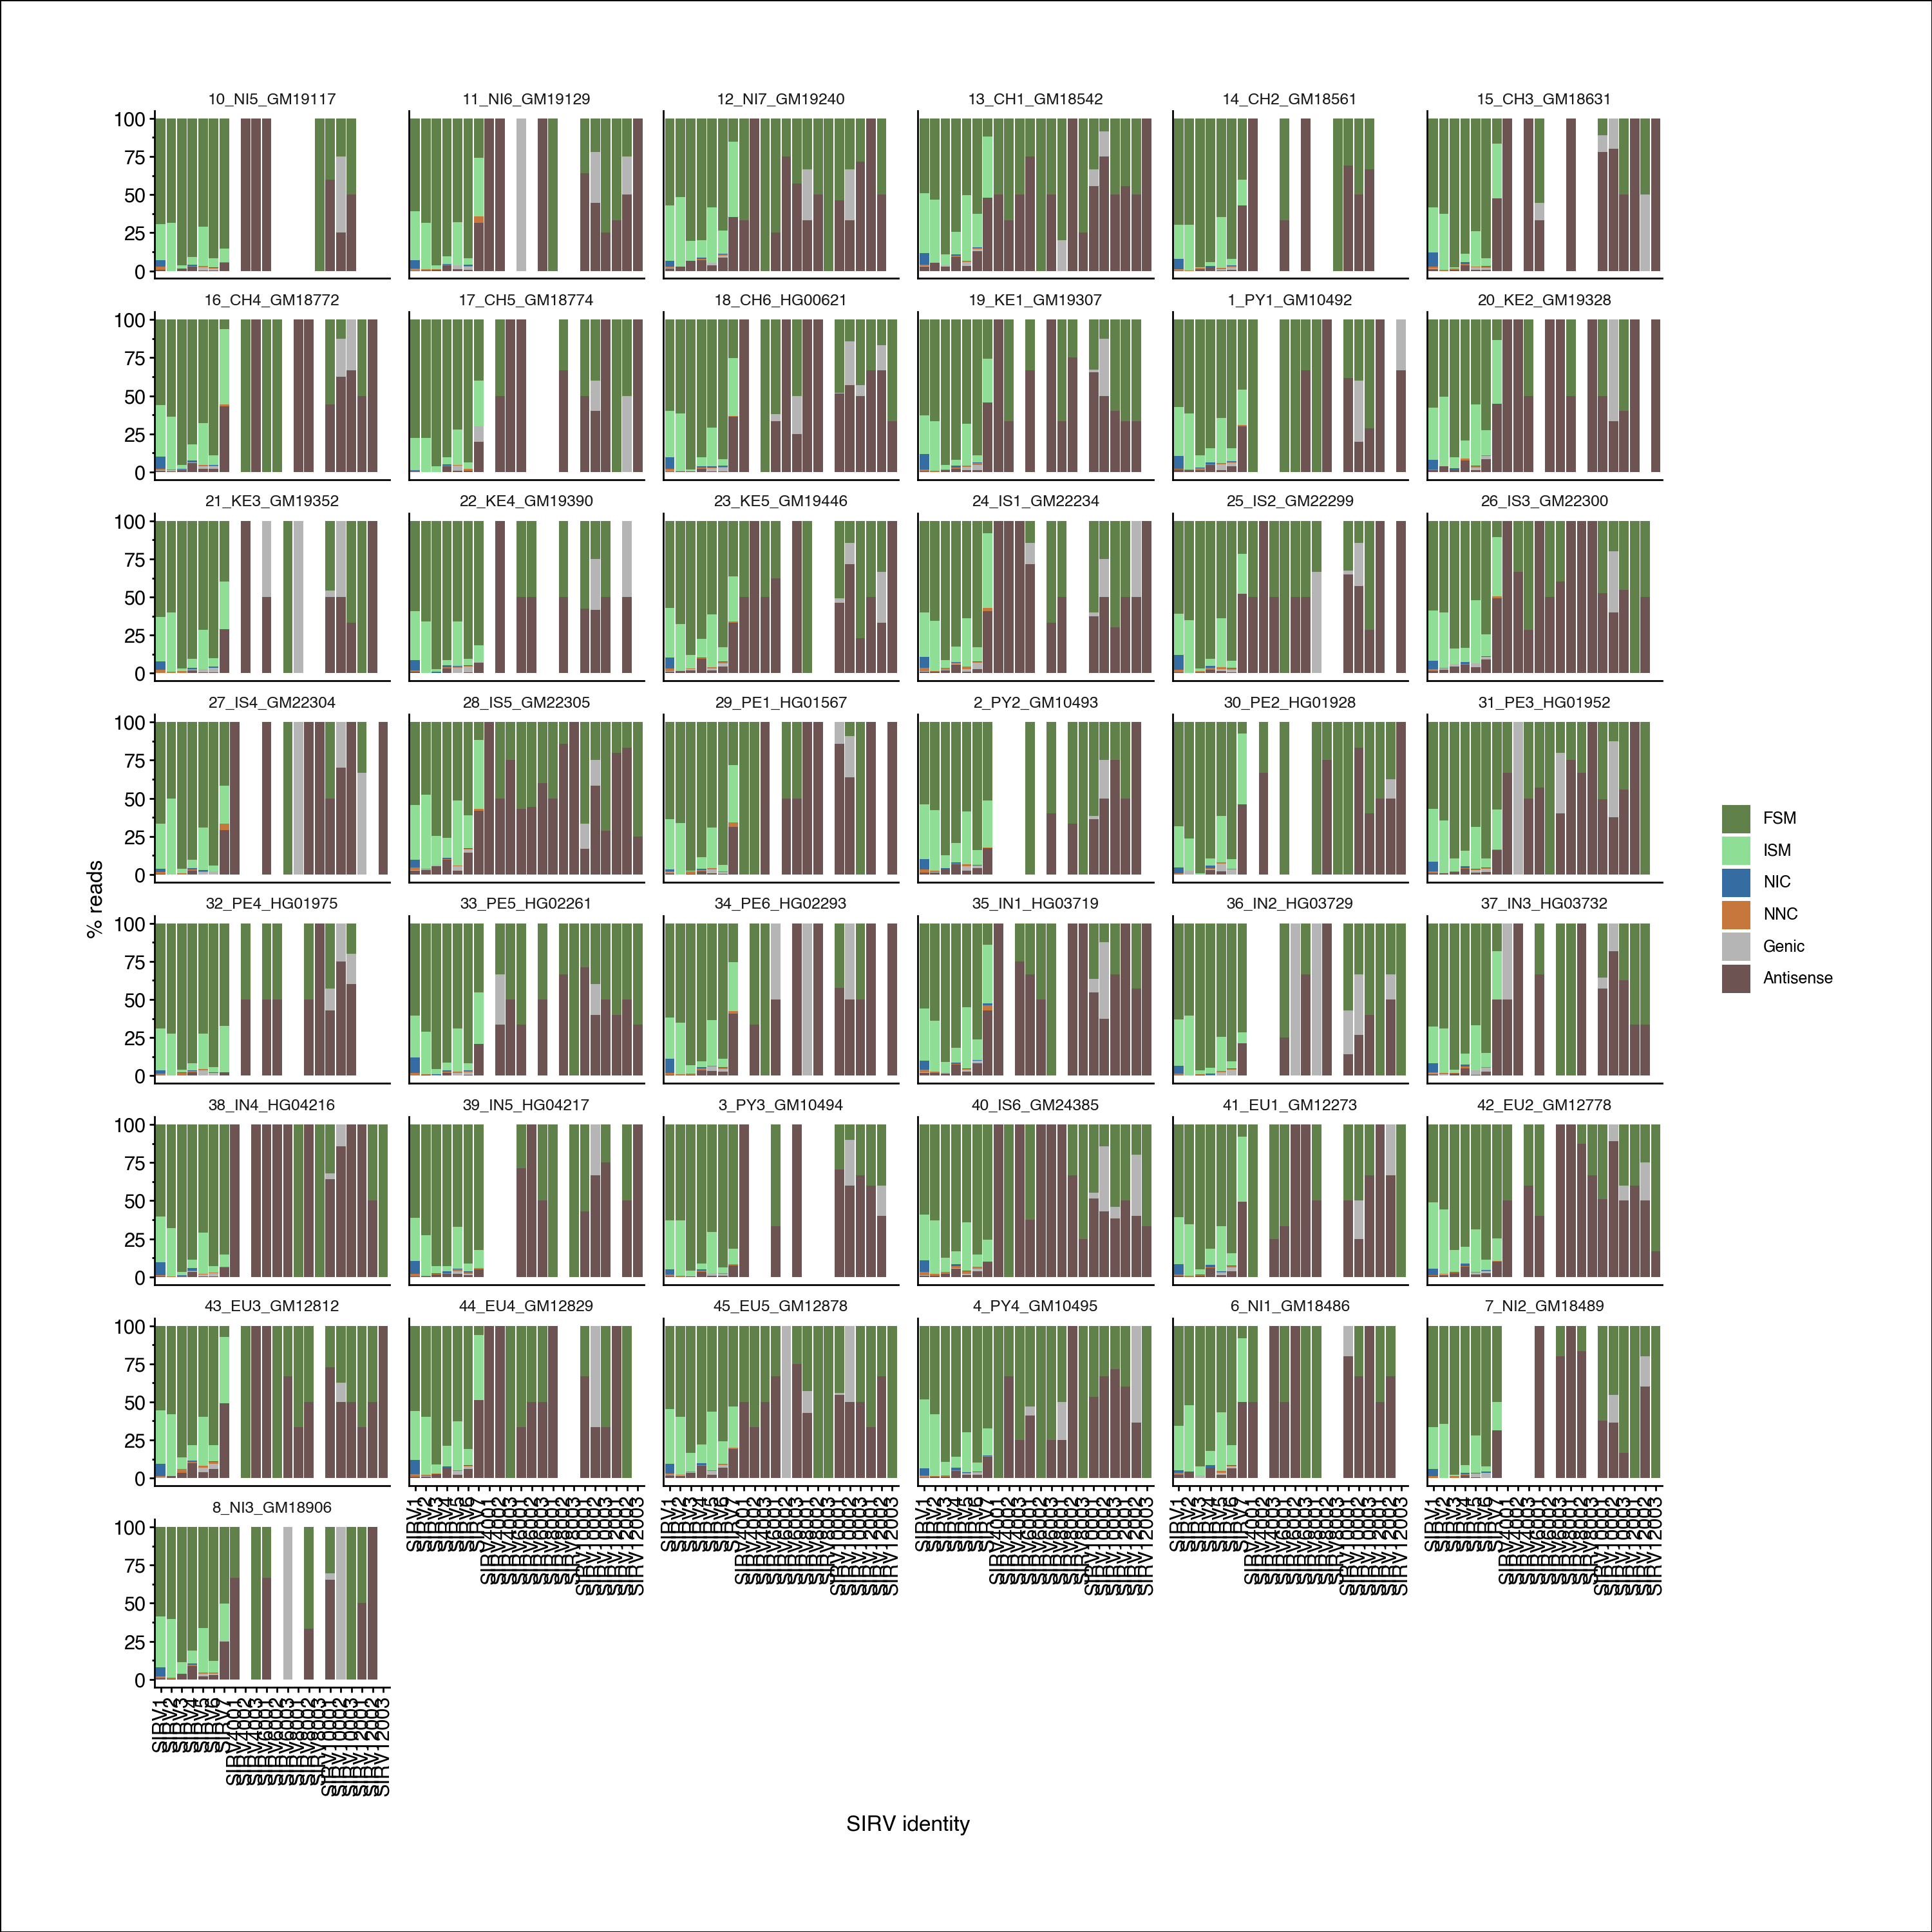

/Users/fairliereese/miniconda3/envs/plotnine_test/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 7 x 4 in image.
/Users/fairliereese/miniconda3/envs/plotnine_test/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: sirv_novelty_by_sample.pdf


In [33]:
temp = df.loc[df.spike_type == 'SIRV']
temp['n_reads_sirv'] = temp.groupby(['assc_gene_2', 'lab_sample'])['isoform'].transform('nunique')
temp['n_reads_sirv_cat'] = temp.groupby(['assc_gene_2', 'structural_category', 'lab_sample'])['isoform'].transform('nunique')

temp['perc'] = (temp.n_reads_sirv_cat/temp.n_reads_sirv)*100
temp = temp[['assc_gene_2', 'structural_category', 'perc', 'lab_sample']].drop_duplicates()

c_dict, order = get_novelty_colors(temp.structural_category.unique().tolist())
temp['assc_gene_2'] = pd.Categorical(temp['assc_gene_2'], categories=sirv_order, ordered=True)
temp['structural_category'] = pd.Categorical(temp['structural_category'], categories=order, ordered=True)

p = (
    ggplot(temp, aes(x='assc_gene_2', y='perc', fill='factor(structural_category)'))
    + geom_bar(stat='identity', position='stack')
    + scale_fill_manual(c_dict)
    + facet_wrap('~lab_sample', ncol=6)
    + labs(
        x='SIRV identity',
        y='% reads',
        fill='Read structural category'
    )
    + my_theme(w=15, h=15)
    + theme(axis_text_x=element_text(rotation=90))
)
p.show()
p.save('sirv_novelty_by_sample.pdf', width=7, height=4, dpi=500)


## What % of the SIRVs do we detect a FSM of in across the entire dataset?

In [40]:
n_sirvs = 84

temp = df.loc[(df.structural_category=='FSM')&\
              (df.spike_type=='SIRV')]
n_fsm_det = len(temp.associated_transcript.unique())
print(f'Detected {n_fsm_det}/{n_sirvs} ({(n_fsm_det/n_sirvs)*100:.2f})% SIRVs w/ an FSM at least once')

Detected 84/84 (100.00)% SIRVs w/ an FSM at least once


## What about when we look sample by sample?

In [59]:
n_sirvs = 84

n_sirvs_fsm_det = []
for s in df.lab_sample.unique().tolist():
    temp = df.loc[(df.structural_category=='FSM')&\
                  (df.spike_type=='SIRV')&\
                  (df.lab_sample==s)]
    n_fsm_det = len(temp.associated_transcript.unique())
    # print(f'Detected {n_fsm_det}/{n_sirvs} ({(n_fsm_det/n_sirvs)*100:.2f})% SIRVs w/ an FSM at least once')
    n_sirvs_fsm_det.append(n_fsm_det)

temp = pd.DataFrame()
temp['n_sirvs_fsm'] = n_sirvs_fsm_det
temp['n_sirvs_tot'] = n_sirvs
temp['perc'] = (temp.n_sirvs_fsm/temp.n_sirvs_tot)*100
temp['lab_sample'] = df.lab_sample.unique().tolist()

In [114]:
# init_plot_settings(aspect='square')
# ax = sns.boxplot(temp,
#                  y='perc')
# clean_figure(ax)
# ax.set(ylabel='% SIRVs detected w/ an FSM')
# plt.show()

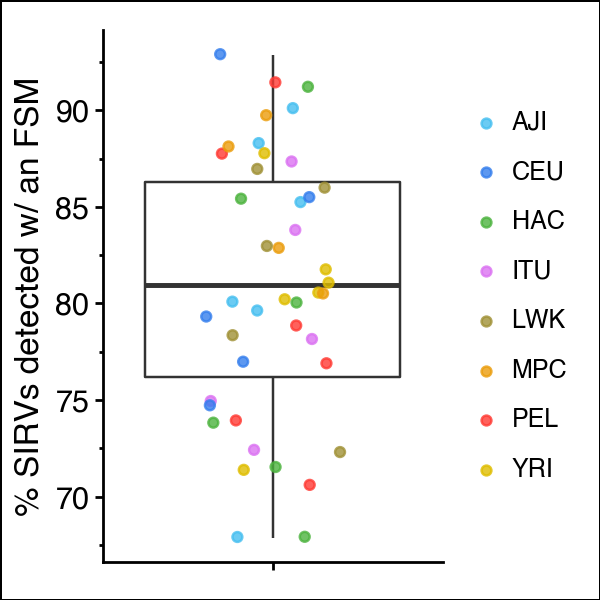

In [63]:


# version with the swarm plot and color the dots by population
temp = temp.merge(meta_df[['lab_sample', 'population']], 
                  how='left', on='lab_sample')

pop_c_dict, pop_order = get_population_colors()

p = (ggplot(temp, aes(y='perc', x='""'))
    + geom_boxplot(outlier_shape=None)
    + geom_jitter(aes(color='population'), width=0.2, size=1.5, alpha=0.8)
    + scale_color_manual(values=pop_c_dict)
    + my_theme(h=3, w=3)
    + labs(
        y='% SIRVs detected w/ an FSM',
        x='')
    )
p.show()

## Now let's look "isoform" by "isoform" for the spiked sirvs only

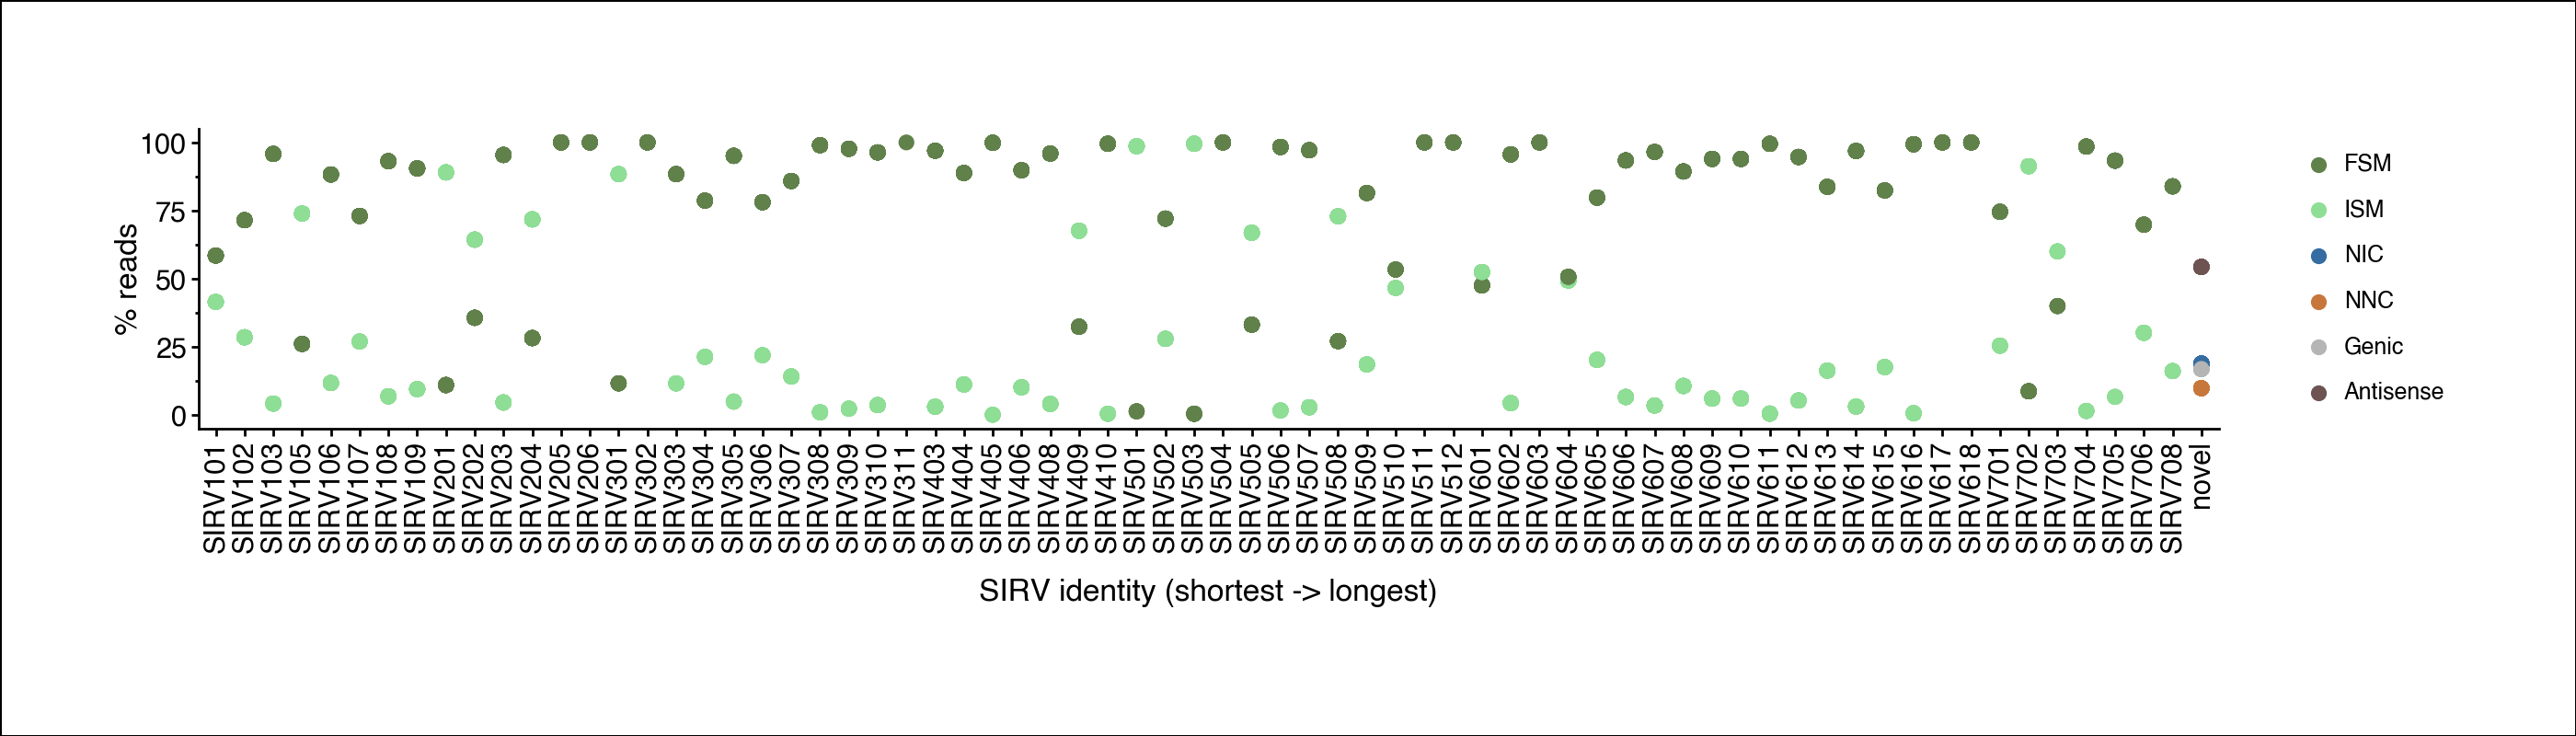

In [103]:
df['spike_type_2'] = df.spike_type

spliced_sirvs = ['SIRV1', 'SIRV2', 'SIRV3', 'SIRV4', 'SIRV5', 'SIRV6', 'SIRV7']
df.loc[df.chrom.isin(spliced_sirvs), 'spike_type_2'] = 'spliced_sirv'
temp = df.loc[df.spike_type_2=='spliced_sirv']

# merge in transcript length
temp = temp.merge(gtf_df[['transcript_id', 'transcript_len']].drop_duplicates(),
                  how='left',
                  left_on='associated_transcript',
                  right_on='transcript_id')


temp = temp.sort_values(by='transcript_len', ascending=True)

temp['n_reads_sirv'] = temp.groupby('associated_transcript')['isoform'].transform('nunique')
temp['n_reads_sirv_cat'] = temp.groupby(['associated_transcript', 'structural_category'])['isoform'].transform('nunique')

c_dict, order = get_novelty_colors(temp.structural_category.unique().tolist())
temp['structural_category'] = pd.Categorical(temp['structural_category'], categories=order, ordered=True)

temp['perc'] = (temp.n_reads_sirv_cat/temp.n_reads_sirv)*100
temp = temp[['associated_transcript', 'structural_category', 'perc', 'lab_sample']].drop_duplicates()

(
    ggplot(temp, aes(x='associated_transcript', y='perc', color='structural_category'))
    + geom_point(size=2.5)
    + scale_color_manual(values=c_dict)
    + labs(
        x='SIRV identity (shortest -> longest)',
        y='% reads',
        color='Read structural category'
    )
    + my_theme(w=14, h=4)
    + theme(axis_text_x=element_text(rotation=90))
)

# this one isn't that helpful

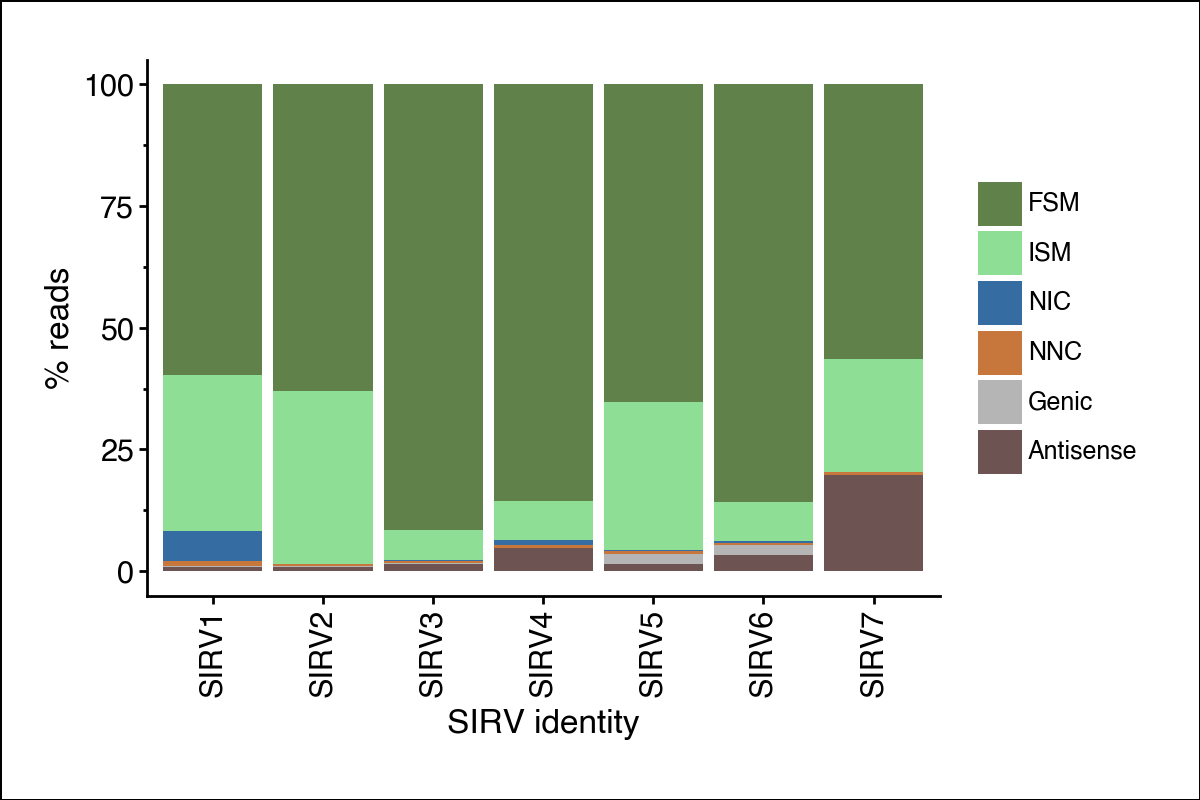

In [111]:
df['spike_type_2'] = df.spike_type

spliced_sirvs = ['SIRV1', 'SIRV2', 'SIRV3', 'SIRV4', 'SIRV5', 'SIRV6', 'SIRV7']
df.loc[df.chrom.isin(spliced_sirvs), 'spike_type_2'] = 'spliced_sirv'
temp = df.loc[df.spike_type_2=='spliced_sirv']

# merge in transcript length
temp = temp.merge(gtf_df[['transcript_id', 'transcript_len']].drop_duplicates(),
                  how='left',
                  left_on='associated_transcript',
                  right_on='transcript_id')


temp = temp.sort_values(by='transcript_len', ascending=True)

temp['n_reads_sirv'] = temp.groupby('assc_gene_2')['isoform'].transform('nunique')
temp['n_reads_sirv_cat'] = temp.groupby(['assc_gene_2', 'structural_category'])['isoform'].transform('nunique')

c_dict, order = get_novelty_colors(temp.structural_category.unique().tolist())
temp['structural_category'] = pd.Categorical(temp['structural_category'], categories=order, ordered=True)

temp['perc'] = (temp.n_reads_sirv_cat/temp.n_reads_sirv)*100
temp = temp[['assc_gene_2', 'structural_category', 'perc']].drop_duplicates()


(
    ggplot(temp, aes(x='assc_gene_2', y='perc', fill='factor(structural_category)'))
    + geom_bar(stat='identity', position='stack')
    +scale_fill_manual(c_dict)
    # + scale_y_continuous(labels=percent_format(), expand=(0, 0))
    + labs(
        x='SIRV identity',
        y='% reads',
        fill='Read structural category'
    )
    + my_theme(w=6, h=4)
    + theme(axis_text_x=element_text(rotation=90))
)

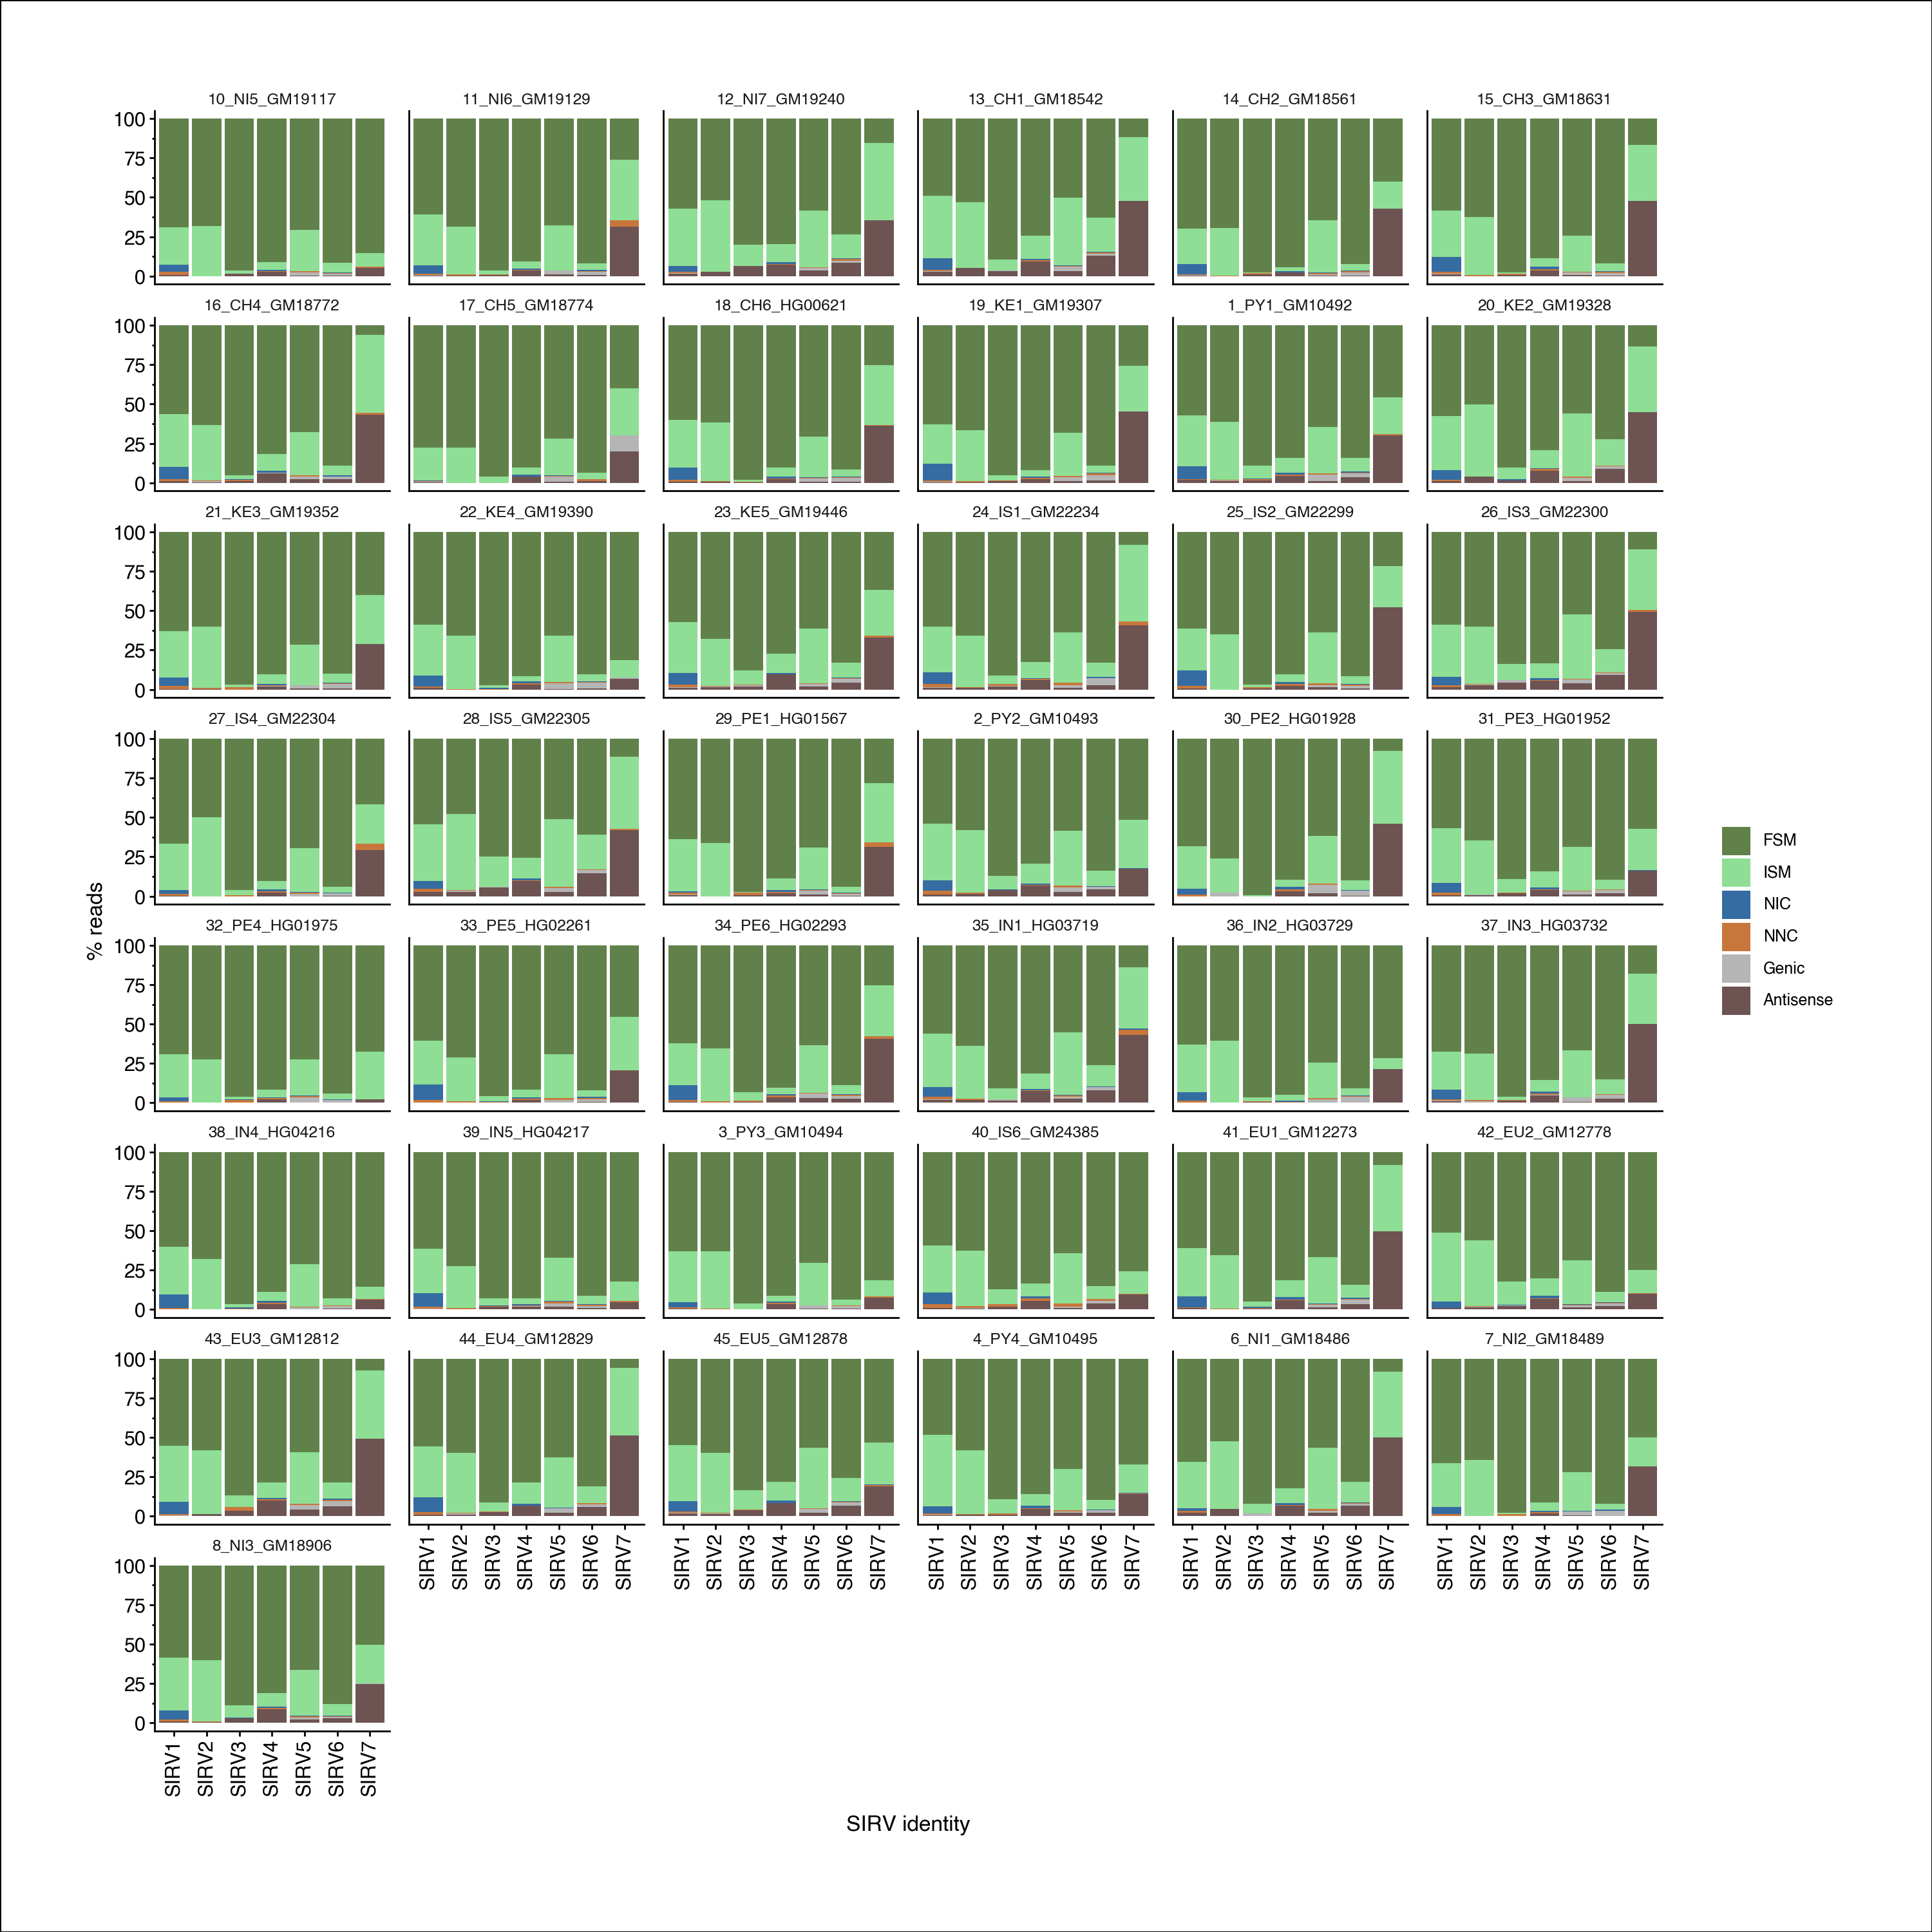

/Users/fairliereese/miniconda3/envs/plotnine_test/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 7 x 4 in image.
/Users/fairliereese/miniconda3/envs/plotnine_test/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: sirv_novelty_by_sample.pdf
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


In [137]:
df['spike_type_2'] = df.spike_type

spliced_sirvs = ['SIRV1', 'SIRV2', 'SIRV3', 'SIRV4', 'SIRV5', 'SIRV6', 'SIRV7']
df.loc[df.chrom.isin(spliced_sirvs), 'spike_type_2'] = 'spliced_sirv'
temp = df.loc[df.spike_type_2=='spliced_sirv']

# merge in transcript length
temp = temp.merge(gtf_df[['transcript_id', 'transcript_len']].drop_duplicates(),
                  how='left',
                  left_on='associated_transcript',
                  right_on='transcript_id')


temp = temp.sort_values(by='transcript_len', ascending=True)

temp['n_reads_sirv'] = temp.groupby(['assc_gene_2', 'lab_sample'])['isoform'].transform('nunique')
temp['n_reads_sirv_cat'] = temp.groupby(['assc_gene_2', 'structural_category', 'lab_sample'])['isoform'].transform('nunique')

temp['perc'] = (temp.n_reads_sirv_cat/temp.n_reads_sirv)*100
temp = temp[['assc_gene_2', 'structural_category', 'perc', 'lab_sample']].drop_duplicates()

c_dict, order = get_novelty_colors(temp.structural_category.unique().tolist())
temp['assc_gene_2'] = pd.Categorical(temp['assc_gene_2'], categories=sirv_order, ordered=True)
temp['structural_category'] = pd.Categorical(temp['structural_category'], categories=order, ordered=True)

# version with the swarm plot and color the dots by population
temp = temp.merge(meta_df[['lab_sample', 'population']], 
                  how='left', on='lab_sample')

p = (
    ggplot(temp, aes(x='assc_gene_2', y='perc', fill='factor(structural_category)'))
    + geom_bar(stat='identity', position='stack')
    + scale_fill_manual(c_dict)
    + facet_wrap('~lab_sample', ncol=6)
    + labs(
        x='SIRV identity',
        y='% reads',
        fill='Read structural category'
    )
    + my_theme(w=15, h=15)
    + theme(axis_text_x=element_text(rotation=90))
)
p.show()
p.save('sirv_novelty_by_sample.pdf', width=7, height=4, dpi=500)


## % of reads from spliced sirvs that are different categories, per library

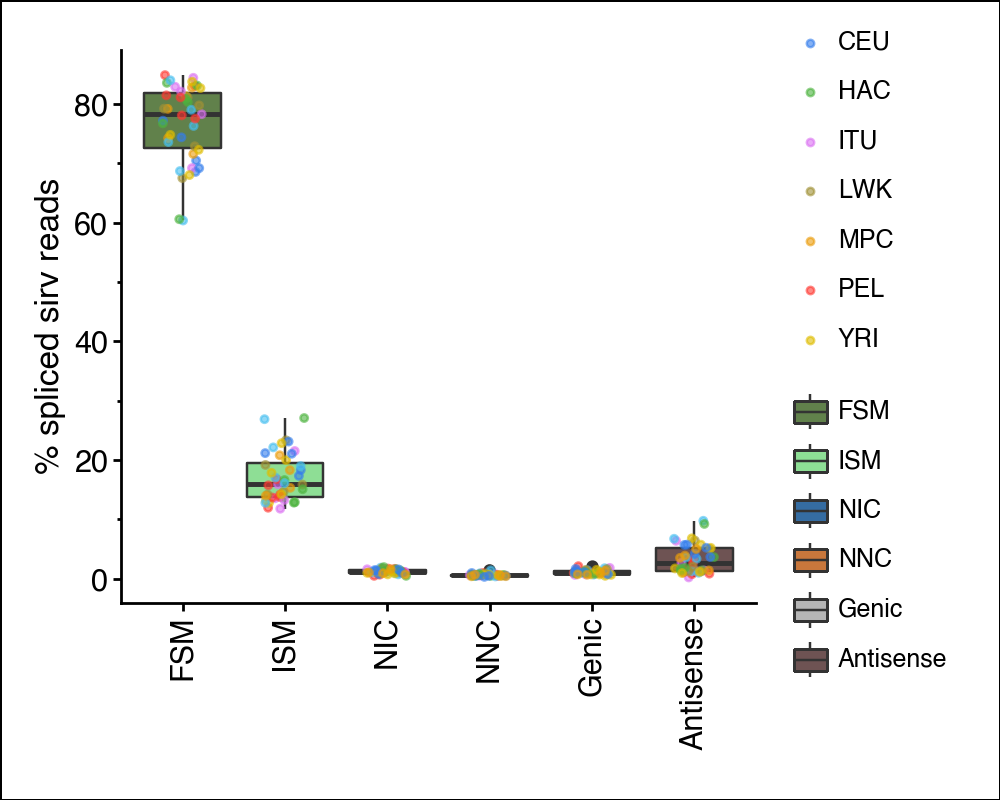

In [151]:
# USE THIS PLOT

df['spike_type_2'] = df.spike_type

spliced_sirvs = ['SIRV1', 'SIRV2', 'SIRV3', 'SIRV4', 'SIRV5', 'SIRV6', 'SIRV7']
df.loc[df.chrom.isin(spliced_sirvs), 'spike_type_2'] = 'spliced_sirv'
temp = df.loc[df.spike_type_2=='spliced_sirv']

# merge in transcript length
temp = temp.merge(gtf_df[['transcript_id', 'transcript_len']].drop_duplicates(),
                  how='left',
                  left_on='associated_transcript',
                  right_on='transcript_id')


temp = temp.sort_values(by='transcript_len', ascending=True)

temp['n_reads_sirv'] = temp.groupby(['lab_sample'])['isoform'].transform('nunique')
temp['n_reads_sirv_cat'] = temp.groupby(['structural_category', 'lab_sample'])['isoform'].transform('nunique')

temp['perc'] = (temp.n_reads_sirv_cat/temp.n_reads_sirv)*100
temp = temp[['structural_category', 'perc', 'lab_sample']].drop_duplicates()

c_dict, order = get_novelty_colors(temp.structural_category.unique().tolist())
temp['structural_category'] = pd.Categorical(temp['structural_category'], categories=order, ordered=True)

# version with the swarm plot and color the dots by population
temp = temp.merge(meta_df[['lab_sample', 'population']], 
                  how='left', on='lab_sample')

p = (
    ggplot(temp, aes(x='structural_category', y='perc'))
    + geom_boxplot(aes(fill='structural_category'), outlier_shape=None)
    + geom_jitter(aes(color='population'), width=0.2, size=1, alpha=0.6)
    + scale_color_manual(values=pop_c_dict)
    + scale_fill_manual(c_dict)
    # + facet_wrap('~lab_sample', ncol=6)
    + labs(
        x='',
        y='% spliced SIRV reads',
        fill='Read structural category'
    )
    + my_theme(w=5, h=4)
    + theme(axis_text_x=element_text(rotation=90))
)
p.show()

## % spliced sirvs only detected w/ an FSM

In [152]:
print(n_spliced_sirvs_tot)

n_sirvs_fsm_det = []
for s in df.lab_sample.unique().tolist():
    temp = df.loc[(df.structural_category=='FSM')&\
                  (df.spike_type_2=='spliced_sirv')&\
                  (df.lab_sample==s)]
    n_fsm_det = len(temp.associated_transcript.unique())
    # print(f'Detected {n_fsm_det}/{n_sirvs} ({(n_fsm_det/n_sirvs)*100:.2f})% SIRVs w/ an FSM at least once')
    n_sirvs_fsm_det.append(n_fsm_det)

temp = pd.DataFrame()
temp['n_sirvs_fsm'] = n_sirvs_fsm_det
temp['n_sirvs_tot'] = n_spliced_sirvs_tot
temp['perc'] = (temp.n_sirvs_fsm/temp.n_sirvs_tot)*100
temp['lab_sample'] = df.lab_sample.unique().tolist()

69


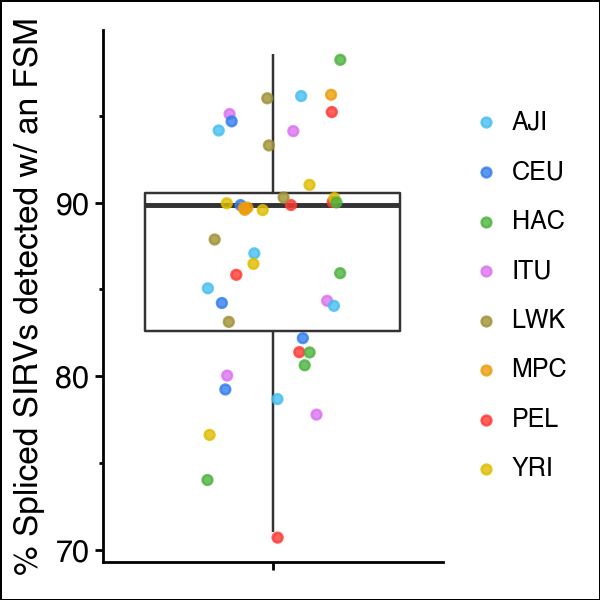

In [153]:
meta_df['lab_sample'] = meta_df['lab_number_sample'].astype(str)+'_'+\
                        meta_df['lab_sampleid']+'_'+\
                        meta_df['cell_line_id']

# version with the swarm plot and color the dots by population
temp = temp.merge(meta_df[['lab_sample', 'population']], 
                  how='left', on='lab_sample')

pop_c_dict, pop_order = get_population_colors()

p = (ggplot(temp, aes(y='perc', x='""'))
    + geom_boxplot(outlier_shape=None)
    + geom_jitter(aes(color='population'), width=0.2, size=1.5, alpha=0.8)
    + scale_color_manual(values=pop_c_dict)
    + my_theme(h=3, w=3)
    + labs(
        y='% Spliced SIRVs detected w/ an FSM',
        x='')
    )
p.show()

## Sensitivity / precision
* Spliced SIRVs only
* We could define these multiple ways
    - By using / comparing the different annotations
    - By implementing our filtering
* True positives = FSMs from complete
* False positives = novel
* True negatives = ??
* False negatives = ??


Other considerations
* We could also compute these values for each SIRV, or for the entire set as a whole (done below)
* Additionally, we could do this in terms of binary detection ie, detected or not at all? This would make false negatives countable on a per-library basis at least
* How do we want to consider ISMs?

### Precision

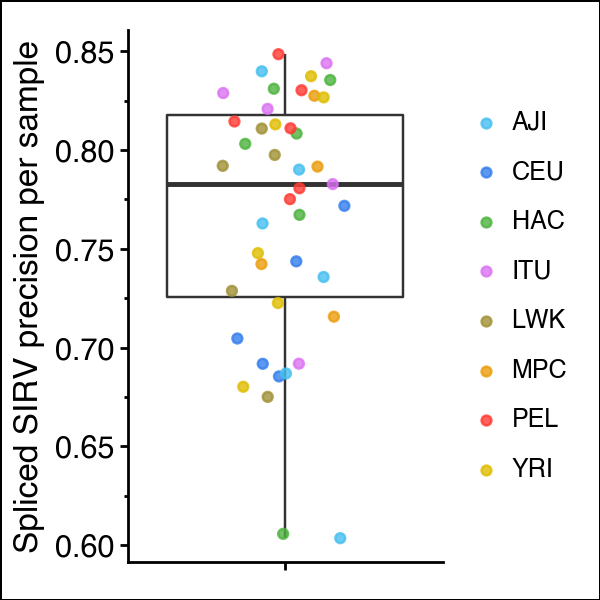

In [161]:
# computed across entire library

df['spike_type_2'] = df.spike_type

spliced_sirvs = ['SIRV1', 'SIRV2', 'SIRV3', 'SIRV4', 'SIRV5', 'SIRV6', 'SIRV7']
df.loc[df.chrom.isin(spliced_sirvs), 'spike_type_2'] = 'spliced_sirv'
temp = df.loc[df.spike_type_2=='spliced_sirv']

# merge in transcript length
temp = temp.merge(gtf_df[['transcript_id', 'transcript_len']].drop_duplicates(),
                  how='left',
                  left_on='associated_transcript',
                  right_on='transcript_id')


temp = temp.sort_values(by='transcript_len', ascending=True)

temp['n_reads_sirv'] = temp.groupby(['lab_sample'])['isoform'].transform('nunique')
temp['n_reads_sirv_cat'] = temp.groupby(['structural_category', 'lab_sample'])['isoform'].transform('nunique')

# drop dupes and keep only FSMs to compute precision
temp = temp[['lab_sample', 'n_reads_sirv',
             'n_reads_sirv_cat', 'structural_category']].drop_duplicates()
temp = temp.loc[temp.structural_category=='FSM']
temp['precision'] = (temp.n_reads_sirv_cat/temp.n_reads_sirv)

temp = temp.merge(meta_df[['lab_sample', 'population']], 
                  how='left', on='lab_sample')

pop_c_dict, pop_order = get_population_colors()

p = (ggplot(temp, aes(y='precision', x='""'))
    + geom_boxplot(outlier_shape=None)
    + geom_jitter(aes(color='population'), width=0.2, size=1.5, alpha=0.8)
    + scale_color_manual(values=pop_c_dict)
    + my_theme(h=3, w=3)
    + labs(
        y='Spliced SIRV precision per sample',
        x='')
    )
p.show()

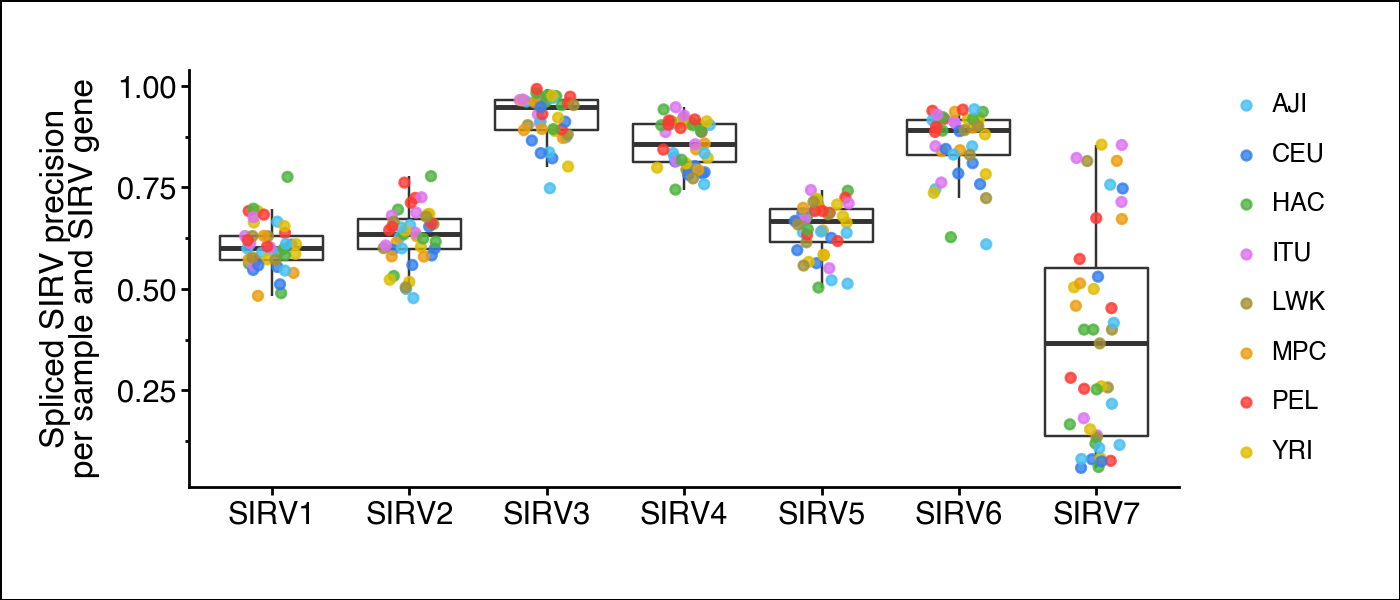

In [165]:
# now compute it also on the sirv gene level
# computed across entire library

df['spike_type_2'] = df.spike_type

spliced_sirvs = ['SIRV1', 'SIRV2', 'SIRV3', 'SIRV4', 'SIRV5', 'SIRV6', 'SIRV7']
df.loc[df.chrom.isin(spliced_sirvs), 'spike_type_2'] = 'spliced_sirv'
temp = df.loc[df.spike_type_2=='spliced_sirv']

# merge in transcript length
temp = temp.merge(gtf_df[['transcript_id', 'transcript_len']].drop_duplicates(),
                  how='left',
                  left_on='associated_transcript',
                  right_on='transcript_id')


temp = temp.sort_values(by='transcript_len', ascending=True)

temp['n_reads_sirv'] = temp.groupby(['lab_sample', 'assc_gene_2'])['isoform'].transform('nunique')
temp['n_reads_sirv_cat'] = temp.groupby(['structural_category', 'lab_sample', 'assc_gene_2'])['isoform'].transform('nunique')

# drop dupes and keep only FSMs to compute precision
temp = temp[['lab_sample', 'n_reads_sirv', 'assc_gene_2',
             'n_reads_sirv_cat', 'structural_category']].drop_duplicates()
temp = temp.loc[temp.structural_category=='FSM']
temp['precision'] = (temp.n_reads_sirv_cat/temp.n_reads_sirv)

temp = temp.merge(meta_df[['lab_sample', 'population']], 
                  how='left', on='lab_sample')

pop_c_dict, pop_order = get_population_colors()

p = (ggplot(temp, aes(y='precision', x='assc_gene_2'))
    + geom_boxplot(outlier_shape='')
    + geom_jitter(aes(color='population'), width=0.2, size=1.5, alpha=0.8)
    + scale_color_manual(values=pop_c_dict)
    + my_theme(h=3, w=7)
    + labs(
        y='Spliced SIRV precision\nper sample and SIRV gene',
        x='')
    )
p.show()

In [171]:
# why does sirv 7 suck so much? Also plot by n_exons and transcript length
temp = temp.merge(gtf_df[['gene_id', 'mean_transcript_len', 'med_transcript_len',
                          'mean_n_exons', 'med_n_exons']].drop_duplicates(),
                  how='left',
                  left_on='assc_gene_2',
                  right_on='gene_id')
assert len(temp.loc[temp.med_n_exons.isnull()]) == 0

In [173]:
value_vars = ['mean_n_exons', 'med_n_exons', 'mean_transcript_len', 'med_transcript_len']

temp_melted = pd.melt(
    temp,
    id_vars=[col for col in temp.columns if col not in value_vars],
    value_vars=value_vars,
    var_name='gene_characteristic_type',
    value_name='gene_characteristic')

p = (ggplot(temp_melted, aes(y='precision', x='gene_characteristic'))
    + geom_point(aes(color='population'), size=1.5, alpha=0.8)
    + scale_color_manual(values=pop_c_dict)
    + facet_wrap('~gene_characteristic_type', ncol=2, scales='free_x')
    + my_theme(h=3, w=7)
    + labs(
        y='Spliced SIRV precision\nper sample and SIRV gene',
        x='')
    )
p.show()

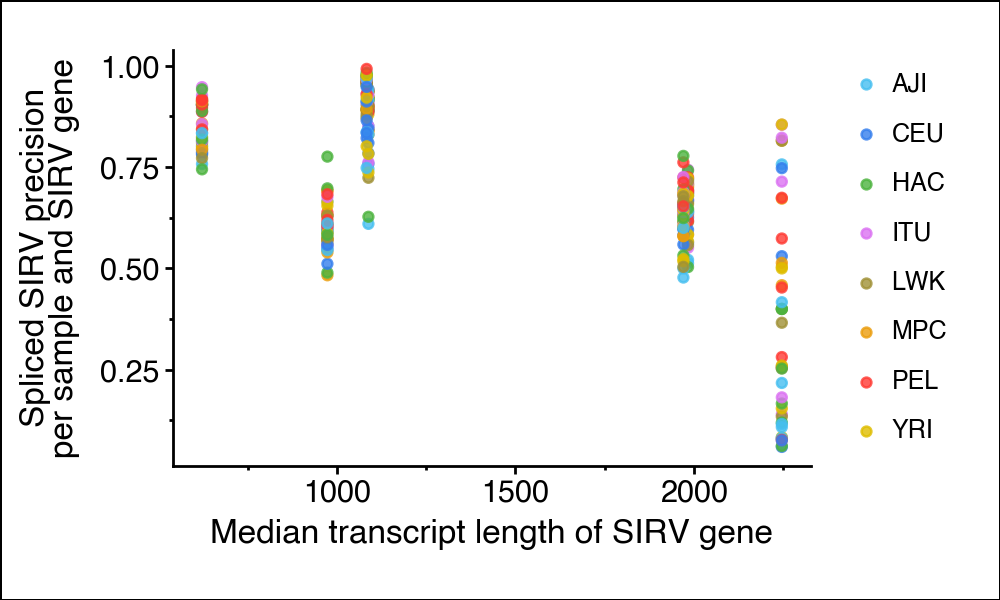

In [184]:
p = (ggplot(temp, aes(y='precision', x='med_transcript_len'))
    + geom_point(aes(color='population'), size=1.5, alpha=0.8)
    + scale_color_manual(values=pop_c_dict)
    + my_theme(h=3, w=5)
    + labs(
        y='Spliced SIRV precision\nper sample and SIRV gene',
        x='Median transcript length of SIRV gene')
    )
p.show()

## Evaulate the coverage of the unspliced SIRVs

## Re-create our filtering
* Remove novel transcripts that don't replicate across samples
* Remove ISMs; keep FSMs that we don't see in our data but we do see an ISM